In [2]:
using Plots, LinearAlgebra, Statistics

using LaTeXStrings
using Plots.PlotMeasures

plot_font = "Computer Modern"
font_size = 10
plot_dpi= 100
default(
  fontfamily=plot_font,
  tickfont = font(10, plot_font),
  legendfont = font(10, plot_font),
  guidefontsize = 11,
  guidefontfamily = plot_font,
  linewidth=1, 
  framestyle=:semi, 
  label=nothing, 
  grid=false,
  dpi=plot_dpi,
  foreground_color_legend = nothing
  )

In [ ]:
MAX(p) = 2
FREEZE(p) = 2/sqrt(p)
IGP(p) = 2/sqrt(p) * 2p/(1+p)
LAS(p) = 2/sqrt(p)

ogp_s(p, r, a, l) = r - (r-1) * l - r / 4 * a^2 / (1 + (r-1) * l^p)
function OGP(p,r) 
    value = 2
    for a in IGP(p):0.0005:MAX(p)
        if min(ogp_s.(p, r, a,  0:0.001:1)...) < 0
            value = a
            break
        end
    end
    value
end

function fp_s(aref, a, c) 
    if c==1 && a == aref
        return 0
    else
        return 1 - c - (a - aref * c^2)^2 / 4 / (1-c^2)
    end
end

function fp_s_sub(aref, a, c) 
    if a/aref > c^2
        return fp_s(aref, a, c) 
    else
        return 1 - c
    end
end

function findlocalmaxima(signal::Vector)
    inds = Int[]
    if length(signal)>1
        if signal[1]>signal[2]
            push!(inds,1)
        end
        for i=2:length(signal)-1
            if signal[i-1]<signal[i]>signal[i+1]
                push!(inds,i)
            end
        end
        if signal[end]>signal[end-1]
            push!(inds,length(signal))
        end
    end
    inds
  end

findlocalminima(signal::Vector) = findlocalmaxima(-signal)

function findzeros(signal::Vector)
    inds = []
    if length(signal)>1
        for i=1:length(signal)-1
            if signal[i] * signal[i+1] <= 0
                push!(inds,[i, i+1])
            end
        end
    end
    inds
end

function c_info(aref, a)
    grid = 0:0.0001:1
    ys = fp_s.(aref,a,grid)
    ids = findlocalmaxima(ys)
    ids2 = findlocalminima(ys)
    ids3 = findzeros(ys)

    c_zeros = map(v -> mean(grid[v]), ids3)

    ids = ids[ys[ids] .>= 0 ]
    ids2 = ids2[ys[ids2] .>= 0 ]

    (   
        max = (grid[ids], ys[ids]),
        min = (grid[ids2], ys[ids2]),
        zeros = c_zeros
    )
end

function a_crit(aref)
    grid = 0:0.0001:2
    tmp = false
    a_crit_1 = aref
    a_crit_2 = aref
    for a in grid
        max, min, zer = c_info(aref, a)

        if length(max[2]) > 1 && tmp == false
            a_crit_1 = a
            tmp = true
        end

        if length(zer) > 2
            a_crit_2 = a
            break
        end
    end
    return [a_crit_1, a_crit_2]
end


function parametric_complexity(a, a1)
    if !(a<a1<2)
        return [NaN, NaN, 0]
    end
    infos = c_info(a1, a)
    ms = infos.max[1]
    if length(ms) == 1
        return [NaN, NaN, 0]
    else    
        zer = infos.zeros
        compl = 1 - a1^2/4
        entr = fp_s(a1, a, max(ms...)) 
        return [entr, compl, length(zer) > 2]
    end
end

parametric_complexity (generic function with 1 method)

# Algs

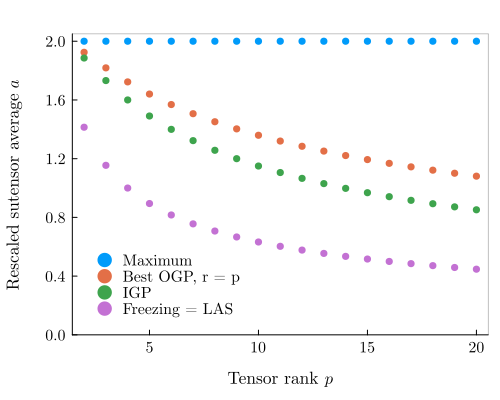

In [3]:
ps = 2:20
fig1 = plot(legend = :bottomleft, xlabel = "\n"*L"Tensor rank $p$", ylabel = L"Rescaled sutensor average $a$"*"\n", yticks = 0:0.4:2, ylim = (0,2.05), title = " ")
scatter!(fig1, MAX, ps, label = "Maximum", markerstrokewidth=0, )
scatter!(fig1, p -> OGP(p,p), ps, label = "Best OGP, r = p", markerstrokewidth=0, )
scatter!(fig1, IGP, ps, label = "IGP", markerstrokewidth=0, )
scatter!(fig1, FREEZE, ps, label = "Freezing = LAS", markerstrokewidth=0)
plot!(fig1, size = (500,400), foreground_color_legend = nothing, background_color_legend = nothing)
savefig(fig1, "OGP.pdf")
fig1

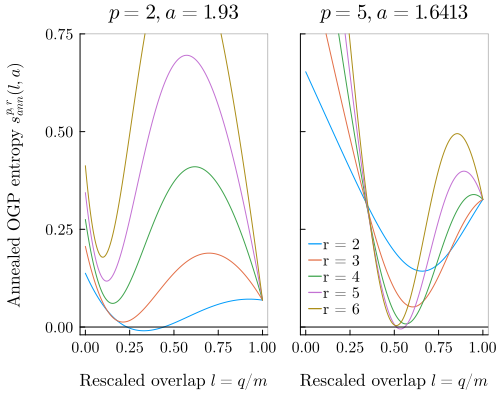

In [ ]:
p = 2
a = 1.93
ls = 0:0.0001:1

fig2 = plot(ylim = (-0.02, 0.75), xlabel = "\n"*L"Rescaled overlap $l = q/m$", ylabel = L"Annealed OGP entropy $s^{p, r}_{\rm ann}(l, a)$"*"\n", title = L"p  = %$p, a = %$a", yticks = 0:0.25:0.75)

for r in 2:6
    plot!(fig2, l -> ogp_s(p, r, a, l), ls, label = :none)
end
hline!(fig2, [0], color = "black", label = :none)

p = 5
a = 1.6413
ls = 0:0.0001:1
fig3 = plot(ylim = (-0.02, 0.75), xlabel = "\n"*L"Rescaled overlap $l = q/m$", title = L"p  = %$p, a = %$a", foreground_color_legend = nothing, legend = :bottomleft, yticks = (0:0.25:0.75, ["", "", "", ""]))
for r in 2:6
    plot!(fig3, l -> ogp_s(p, r, a, l), ls, label = "r = $r")
end
hline!(fig3, [0], color = "black", label = :none)
fig3

fig4 = plot(fig2, fig3, layout = (1, 2))
plot!(fig4, size = (500,400),)

savefig(fig4, "OGP-montonicity.pdf")
fig4

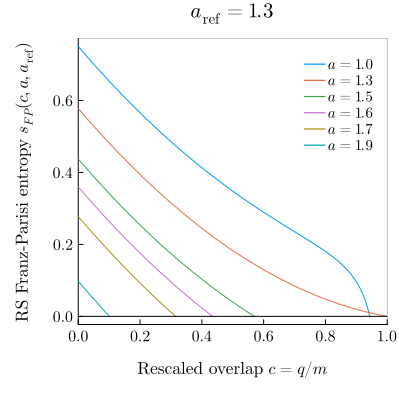

In [5]:
cs = 0:0.001:1
aref = 1.3

fig = plot(xlabel = "\n"*L"Rescaled overlap $c = q/m$", ylabel = L"RS Franz-Parisi entropy $s_{\rm FP}(c, a, a_{\textrm{ref}})$"*"\n", title = L"$a_{\textrm{ref}} = %$aref$",
    size = (400,400), 
    xlim = (0,1), ylim = :auto,
    legend = :topright)


for a in [1., 1.3, 1.5, 1.6, 1.7, 1.9]
    plot!(fig, cs, map(x -> x < 0 ? NaN : x, fp_s.(aref, a, cs)) , label = L"a = %$a")
end

hline!(fig, [0], color = "black", label = :none)

savefig(fig, "FP_curves_2.pdf")
fig

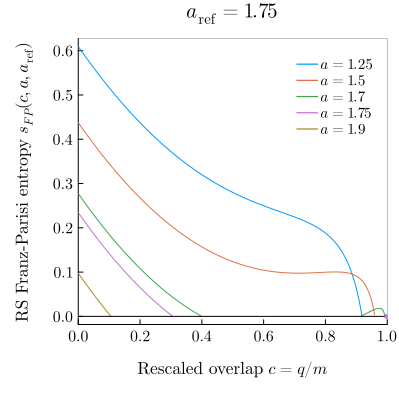

In [6]:
cs = 0:0.001:1
aref = 1.75

fig = plot(xlabel = "\n"*L"Rescaled overlap $c = q/m$", ylabel = L"RS Franz-Parisi entropy $s_{\rm FP}(c, a, a_{\textrm{ref}})$"*"\n", title = L"$a_{\textrm{ref}} = %$aref$",
    size = (400,400), 
    xlim = (0,1), ylim = :auto,
    legend = :topright)


for a in [1.25, 1.5, 1.7, 1.75, 1.9]
    plot!(fig, cs, map(x -> x < 0 ? NaN : x, fp_s.(aref, a, cs)) , label = L"a = %$a")
end

hline!(fig, [0], color = "black", label = :none)


scatter!([1], [0], color = 4,  markerstrokewidth=0, markersize = 3)


savefig(fig, "FP_curves.pdf")
fig

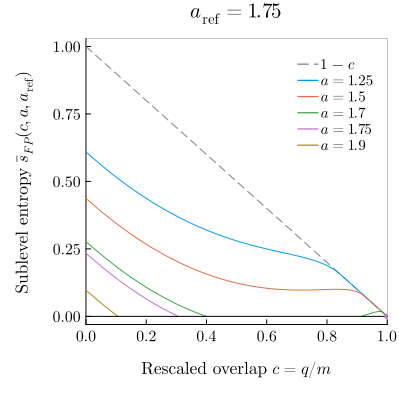

In [7]:
cs = 0:0.001:1
aref = 1.75

fig = plot(xlabel = "\n"*L"Rescaled overlap $c = q/m$", ylabel = L"Sublevel entropy $̅s_{\rm FP}(c, a, a_{\textrm{ref}})$"*"\n", title = L"$a_{\textrm{ref}} = %$aref$",
    size = (400,400), 
    xlim = (0,1), ylim = :auto,
    legend = :topright)

plot!(fig, c -> 1-c, 0:0.1:1, color = "grey", ls = :dash, label = L"1-c")

for (i,a) in enumerate([1.25, 1.5, 1.7, 1.75, 1.9])
    plot!(fig, cs, map(x -> x < 0 ? NaN : x, fp_s_sub.(aref, a, cs)) , label = L"a = %$a", color = i)
end

hline!(fig, [0], color = "black", label = :none)
scatter!(fig, [1], [0], color = 4,  markerstrokewidth=0, markersize = 3)

savefig(fig, "FP_sub_curves.pdf")
fig

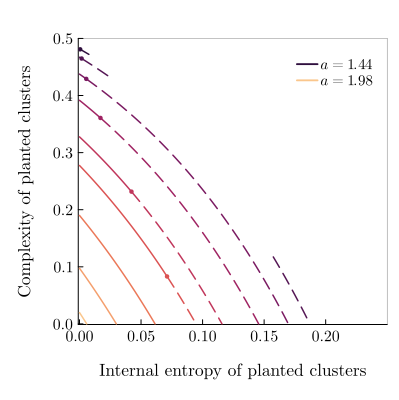

In [ ]:
fig = plot(xlabel = "\nInternal entropy of planted clusters", ylabel = "Complexity of planted clusters\n", size = (400,400), ylim = (-0.001,0.5), xlim = (-0.001, 0.25), legend = :topright, title = " ")
as = [1.44, 1.46, 1.5, 1.56, 1.64, 1.7, 1.8, 1.9, 1.98]

cs = cgrad(:matter, 0.2:0.8/length(as):1, rev = true, categorical = true)

for (i,a) in enumerate(as)
    as1 = vcat(a:0.00005:a+0.01, a+0.0101:0.001:1.96, 1.961:0.00005:2)
    v = parametric_complexity.(a, as1)
    strict = filter(v -> v[3] == 1, v)
    not_strict = filter(v -> v[3] == 0, v)
    label = if i == 1 || i == length(as)
        L"a = %$a"
    else
        :none
    end
    plot!(fig, getindex.(strict,1), getindex.(strict,2), linestyle = :solid, label = label, color = cs[i], linewidth = 1.5)
    plot!(fig, getindex.(not_strict,1), getindex.(not_strict,2), linestyle = :dash, label = :none, color = cs[i], linewidth = 1.5)
    if length(strict) > 0 && length(filter(v -> !isnan(v[1]), not_strict)) > 0 && length(filter(v -> !isnan(v[1]), strict)) > 0
        scatter!(strict[end][1:1], strict[end][2:2], color = cs[i],  markerstrokewidth=0, markersize = 2.5)
    end

end
savefig(fig, "FP_complexity.pdf")
fig

In [9]:
aref_ = vcat(range(start = 0, stop = sqrt(2), length = 10), range(start = sqrt(2), stop = 2, length = 20), [1.44, 1.46, 1.5, 1.56, 1.64, 1.7, 1.8, 1.9, 1.98])
aref_ = sort(unique(aref_))
crits_ = a_crit.(aref_)
crits_ = hcat(crits_...)'
;

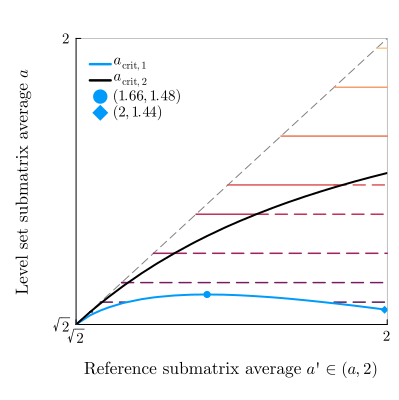

In [ ]:
fig = plot(xlabel = "\n"*L"Reference submatrix average $a' \in (a, 2)$", ylabel = L"Level set submatrix average $a$"*"\n", title = " ",
    size = (400,400), 
    ylim = (sqrt(2),2), xlim = (sqrt(2),2), 
    xticks = ([sqrt(2), 2],[L"\sqrt{2}", L"2"]),
    yticks = ([sqrt(2), 2],[L"\sqrt{2}", L"2"]),
    legend = :topleft)
    
plot!(aref_, aref_, color = :grey, ls = :dash)




as = [1.44, 1.46, 1.5, 1.56, 1.64, 1.7, 1.8, 1.9, 1.98]
cs = cgrad(:matter, 0.2:0.8/length(as):1, rev = true, categorical = true)
for (j,a) in enumerate(as)
    ys1 = map((y,z) -> begin
        if y <= a <= z +1e-2
            a
        else
            NaN
        end
    end, crits_[:, 1], crits_[:, 2])
    plot!(aref_, ys1, color = cs[j], ls = :dash, lw = 1.5)

    ys2 = map((x,z) -> begin
        if z <= a <= x
            a
        else
            NaN
        end
    end, aref_, crits_[:, 2])
    plot!(aref_, ys2, color = cs[j], ls = :solid, lw = 1.5)
end

plot!(fig, aref_, crits_[:, 1], label = L"$a_{\textrm{crit, 1}}$", lw = 2, color = 1)
plot!(fig, aref_, crits_[:, 2], label = L"$a_{\textrm{crit, 2}}$", lw = 2, color = :black)

i = argmax(crits_[:, 1])
scatter!([aref_[i]], [crits_[i, 1]], color = 1, markerstrokewidth=0, label = L"(1.66, 1.48)", markersize = 4)
scatter!([aref_[end]-0.005], [crits_[end, 1]], color = 1, marker = :diamond, markerstrokewidth=0, label = L"(2, 1.44)", markersize = 4)


savefig(fig, "FP_acrits_complexity.pdf")
fig

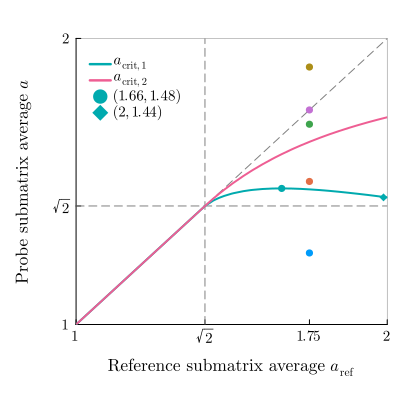

In [11]:
fig = plot(xlabel = "\n"*L"Reference submatrix average $a_{\textrm{ref}}$", ylabel = L"Probe submatrix average $a$"*"\n", title = " ",
    size = (400,400), 
    ylim = (1,2), xlim = (1,2), 
    xticks = ([1, sqrt(2), 1.75, 2],[L"1", L"\sqrt{2}", L"1.75", L"2"]),
    yticks = ([1, sqrt(2), 2],[L"1", L"\sqrt{2}", L"2"]),
    legend = :topleft)

hline!(fig, [sqrt(2)], color = :grey, ls = :dash)
vline!(fig, [sqrt(2)], color = :grey, ls = :dash)
plot!(aref_, aref_, color = :grey, ls = :dash)

plot!(fig, aref_, crits_[:, 1], label = L"$a_{\textrm{crit, 1}}$", lw = 2, color = 6)
plot!(fig, aref_, crits_[:, 2], label = L"$a_{\textrm{crit, 2}}$", lw = 2, color = 7)

i = argmax(crits_[:, 1])
scatter!([aref_[i]], [crits_[i, 1]], color = 6, markerstrokewidth=0, label = L"(1.66, 1.48)", markersize = 4)
scatter!([aref_[end]-0.012], [crits_[end, 1]], color = 6, marker = :diamond, markerstrokewidth=0, label = L"(2, 1.44)", markersize = 4)


aref0 = 1.75
for (j,a) in enumerate([1.25, 1.5, 1.7, 1.75, 1.9])
    scatter!([aref0], [a], color = j, markerstrokewidth=0, markersize = 4)
end

savefig(fig, "FP_acrits.pdf")
fig

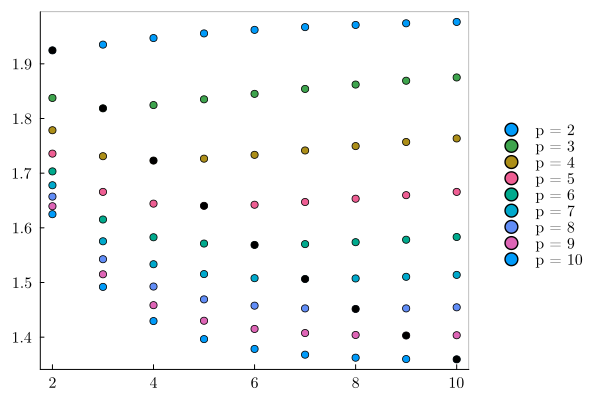

In [12]:
fig = plot(legend = :outerright)
for p in 2:10
    rs = 2:10
    ys = map(r -> OGP(p,r), rs)
    scatter!(fig, rs, ys, label = "p = $p")
    i = argmin(ys)
    scatter!(fig, rs[i:i], ys[i:i], color = "black", label = :none)
end
fig